In [1]:
import tarfile
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
url = 'http://udon.stacken.kth.se/~ninjin/comp0090_assignment_1_data.tar.gz'
ftpstream = urllib.request.urlopen(url)
tar = tarfile.open(fileobj=ftpstream, mode="r|gz")
tar.extractall()
tar.close

<bound method TarFile.close of <tarfile.TarFile object at 0x000002581BF0AD68>>

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


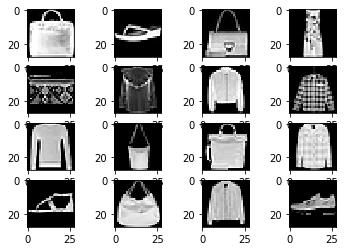

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

In [6]:
# reshape data to make it easier to work with
trainxs = trainxs.reshape(-1, 784)
devxs = devxs.reshape(-1, 784)
testxs = testxs.reshape(-1, 784)

In [7]:
# function to create weight and sum parameters for the algorithm
def initialise_parameters(xs):
    w = np.zeros(xs.shape[1])
    b = 0
    return w, b

In [8]:
def logistic_func(x):
    return 1/(1 + np.exp(-x))

def logistic_der(x):
    return logistic_func(x) * (1 - logistic_func(x))

def f(x, w, b):
    return logistic_func(np.dot(w, x) + b)

def p(x, w, b):
    if f(x, w, b) >= 0.5:
        return 1
    return 0

In [9]:
#Measure Accuracy

def accuracy(xs, ys, w, b):
    correct = 0
    for i in range(xs.shape[0]):
        if p(xs[i], w, b) == ys[i]:
            correct += 1
    return correct/len(xs)*100    

In [10]:
#Loss Function

def loss_func(ys, y_predict):
    sum = 0
    n = ys.shape[0]
    for i in range(n):
        sum += (ys[i] - y_predict[i]) ** 2
    return 1/2*n*sum

In [11]:
#Loss Function for single points

def loss(y, y_hat):
    return ((y - y_hat) ** 2) / 2

In [12]:
def validation_loss(devxs, devys, w, b):
    y_predict = []
    
    for i in range(devxs.shape[0]):
        y_hat = f(devxs[i], w, b)
        y_predict.append(y_hat)
        
    return loss_func(devys, y_predict)

In [34]:
def logistic_regression(trainxs, trainys, devxs, devys):
    w, b = initialise_parameters(trainxs)
    
    accuracy_training = []
    accuracy_validation = []
    
    # store predicted y's and loss for each epoch
    y_predict = []
    loss_training = []
    loss_validation = []
    
    # store old accuracy and consecutive epochs count to detect convergence
    #loss_old = validation_loss(devxs, devys, w, b)
    loss_old = 0
    row_epoch = 0
    
    # store number of epochs to have a nice graph
    epoch = 0
    learning_rate = 0.1
    
    while True:
        print('Epoch', epoch)
        trainxs, trainys = shuffle(trainxs, trainys)
        grad_w, grad_b = initialise_parameters(trainxs)
        y_predict = []

        for i in range(trainxs.shape[0]):
            y_hat = f(trainxs[i], w, b)
            y_predict.append(y_hat)
            grad_w += trainxs[i] * (y_hat - trainys[i]) * (1 - y_hat) * y_hat 
            grad_b += (y_hat - trainys[i]) * (1 - y_hat) * y_hat 

        grad_w /= trainxs.shape[0]
        grad_b /= trainxs.shape[0]
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        accuracy_train = accuracy(trainxs, trainys, w, b)
        accuracy_training.append(accuracy_train)
        print('Training set accuracy:', accuracy(trainxs, trainys, w, b))
        accuracy_dev = accuracy(devxs, devys, w, b)
        accuracy_validation.append(accuracy_dev)
        print('Validation set accuracy:', accuracy_dev)
        
        loss_train = loss_func(trainys, y_predict)
        loss_training.append(loss_train)
        print('Training set loss:', loss_train)
        loss_dev = validation_loss(devxs, devys, w, b)
        loss_validation.append(loss_dev)
        print('Validation set loss:', loss_dev)
        
        # check if converged
        if np.abs(loss_dev - loss_old) < 100:
            row_epoch += 1
            if row_epoch == 5:
                break
        else:
            row_epoch = 0
            
        loss_old = loss_dev
        epoch += 1
    
    return epoch, accuracy_training, accuracy_validation, loss_training, loss_validation

In [35]:
epoch, accuracy_training, accuracy_validation, loss_training, loss_validation = logistic_regression(trainxs, trainys, devxs, devys)

Epoch 0
Training set accuracy: 55.95833333333333
Validation set accuracy: 56.89999999999999
Training set loss: 18000000.0
Validation set loss: 117155.2646123714
Epoch 1
Training set accuracy: 66.4
Validation set accuracy: 68.4
Training set loss: 16931565.468948156
Validation set loss: 111667.47791745214
Epoch 2
Training set accuracy: 71.98333333333333
Validation set accuracy: 71.89999999999999
Training set loss: 16148409.759788767
Validation set loss: 106851.28822965706
Epoch 3
Training set accuracy: 76.40833333333333
Validation set accuracy: 76.2
Training set loss: 15455166.596846003
Validation set loss: 102572.5819794579
Epoch 4
Training set accuracy: 78.34166666666667
Validation set accuracy: 78.8
Training set loss: 14840650.93286683
Validation set loss: 98769.12731742027
Epoch 5
Training set accuracy: 79.48333333333333
Validation set accuracy: 80.2
Training set loss: 14296304.13774796
Validation set loss: 95382.16917298471
Epoch 6
Training set accuracy: 80.15
Validation set accurac

Training set accuracy: 90.85
Validation set accuracy: 92.0
Training set loss: 7460035.568871782
Validation set loss: 49645.398511079875
Epoch 54
Training set accuracy: 91.00833333333334
Validation set accuracy: 92.0
Training set loss: 7408536.559769479
Validation set loss: 49286.25843969878
Epoch 55
Training set accuracy: 91.14999999999999
Validation set accuracy: 92.10000000000001
Training set loss: 7358147.695874266
Validation set loss: 48934.92771781643
Epoch 56
Training set accuracy: 91.28333333333333
Validation set accuracy: 92.2
Training set loss: 7308832.142850308
Validation set loss: 48591.148568652396
Epoch 57
Training set accuracy: 91.38333333333334
Validation set accuracy: 92.4
Training set loss: 7260554.833954775
Validation set loss: 48254.675243929014
Epoch 58
Training set accuracy: 91.50833333333334
Validation set accuracy: 92.60000000000001
Training set loss: 7213282.3476122
Validation set loss: 47925.27323008433
Epoch 59
Training set accuracy: 91.55833333333334
Validati

Training set accuracy: 94.075
Validation set accuracy: 94.89999999999999
Training set loss: 5712438.157748848
Validation set loss: 37513.303571831864
Epoch 107
Training set accuracy: 94.09166666666667
Validation set accuracy: 95.0
Training set loss: 5691636.521059905
Validation set loss: 37369.745919630026
Epoch 108
Training set accuracy: 94.1
Validation set accuracy: 95.0
Training set loss: 5671115.023761169
Validation set loss: 37228.14505545276
Epoch 109
Training set accuracy: 94.10833333333333
Validation set accuracy: 95.0
Training set loss: 5650867.8954810435
Validation set loss: 37088.460374901566
Epoch 110
Training set accuracy: 94.125
Validation set accuracy: 95.0
Training set loss: 5630889.521908746
Validation set loss: 36950.6523782765
Epoch 111
Training set accuracy: 94.15833333333333
Validation set accuracy: 95.0
Training set loss: 5611174.439628839
Validation set loss: 36814.68263378332
Epoch 112
Training set accuracy: 94.20833333333334
Validation set accuracy: 95.19999999

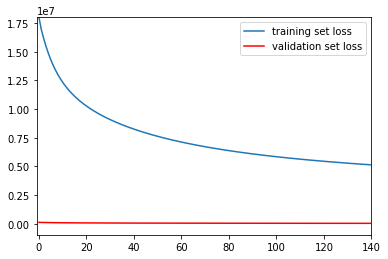

In [37]:
plt.axis([-1, epoch, min(loss_validation) - 1000000, max(loss_training)])
plt.plot(loss_training, label='training set loss')
plt.plot(loss_validation, label='validation set loss', color='r')
plt.legend(loc='upper right')

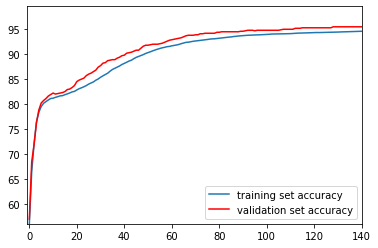

In [38]:
plt.axis([-1, epoch, min(accuracy_training), max(accuracy_training) + 5])
plt.plot(accuracy_training, label='training set accuracy')
plt.plot(accuracy_validation, label='validation set accuracy', color='r')
plt.legend(loc='lower right')

In [39]:
ind = accuracy_validation.index(max(accuracy_validation))
print("Best epoch =", ind)
print("Accuracy on training set =", accuracy_training[ind])
print("Accuracy on validation set =", accuracy_validation[ind])

Best epoch = 128
Accuracy on training set = 94.40833333333333
Accuracy on validation set = 95.5


In [ ]:
def flatten(w, b):
    toflatten = (w, [b])
    vec = np.zeros(sum(len(x) for x in toflatten))
    offset = 0
    for parameter in toflatten:
        vec[offset:offset + len(parameter)] = parameter
        offset += len(parameter)
    return vec

In [ ]:
def unflatten(w, b, vec):
    tounflatten = (w, [b])
    offset = 0
    for parameter in tounflatten:
        parameter[:] = vec[offset:offset + len(parameter)]
        offset += len(parameter)
    return tounflatten

In [ ]:
def fdfprime(w, b, x, y):
    epsilon  = 0.000001
    grad_w = np.zeros_like(w)
    grad_b = 0.0
    vecm     = flatten(w, b)
    vecgradm = flatten(grad_w, grad_b)
    
    for i in range(len(vecm)):
        wi           = vecm[i]

        vecm[i]     += epsilon/2       
        w_j, b_j     = unflatten(grad_w, grad_b, vecm)
        r            = loss(y, f(x, w_j, b_j))
        vecm[i]      = wi
        vecm[i]     -= epsilon/2
        w_j, b_j     = unflatten(grad_w, grad_b, vecm)
        l            = loss(y, f(x, w_j, b_j))
        vecgradm[i]  = (r - l)/epsilon

        vecm[i]      = wi

    return unflatten(grad_w, grad_b, vecgradm)


In [ ]:
def fprime(n, x, y, w, b):
    grad_w = np.zeros(n)
    grad_b = 0.0
    
    #Forward pass
    z = np.dot(w, x) + b
    y_hat = logistic_func(z)
    
    #Backward pass
    grad_z = (y_hat - y) * logistic_der(z)
    grad_w += x * (y_hat - y) * (1 - y_hat) * y_hat 
    grad_b += (y_hat - y) * (1 - y_hat) * y_hat
    
    return (grad_w, [grad_b])

In [ ]:
x = trainxs[0]
y = trainys[0]
w = np.random.random(784) / 100
grad_w, grad_b = fprime(trainxs.shape[1], x, y, w, 0.0)
fd_grad_w, fd_grad_b = fdfprime(w, 0.0, x, y)

In [ ]:
fd_b = np.subtract(fd_grad_b,grad_b)
fd_w = np.subtract(fd_grad_w,grad_w)
max_fd = fd_w.max()
print(fd_b)
print(fd_w)
print("Max difference for w:", max_fd)